# **2023 NFL Big Data Bowl EDA**
### Sol Ben-Ishay

## **Extract+Clean the Data**

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

In [2]:
# Read in data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

In [3]:
#Get the main frame-level tracking df
coi = ['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'playId',
       'playDescription',  'frameId', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'passResult', 'prePenaltyPlayResult',
       'absoluteYardlineNumber', 'yardlineSide','yardlineNumber', 'dropBackType',
       'pff_playAction', 'nflId', 'time', 'team', 'x', 'y', 'o', 'playDirection', 'event',
       'officialPosition', 'displayName','pff_role','pff_positionLinedUp', 'pff_hit',
       'pff_hurry', 'pff_sack','pff_nflIdBlockedPlayer', 'pff_beatenByDefender']

frame_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on= 'nflId', how='left')
                .merge(scouting_df, on=['gameId','playId','nflId']))[coi]

frame_df = frame_df.rename(columns={'defensiveTeam':'defTeam', 'possessionTeam':'offTeam', 'pff_playAction':'playAction',
'officialPosition':'position', 'displayName':'playerName', 'pff_role':'roleOnPlay', 'pff_positionLinedUp':'posLinedUp'})

# Convert up dt_time column to time
frame_df['time'] = pd.to_datetime(frame_df['time'])

# Replace n/a dropBackType and yardlineSide
frame_df = frame_df.fillna(value={'dropBackType': 'none', 'yardlineSide': 'middle'})

# Replace missing n/a absoluteYardlineNumber for a specific play (not sure why)
missing_abs_yd_rows = frame_df.query("absoluteYardlineNumber.isna()").index.to_list()
frame_df.loc[missing_abs_yd_rows,'absoluteYardlineNumber'] = 71.0

frame_df.head()

,gameId,season,week,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,frameId,quarter,down,...,event,position,playerName,roleOnPlay,posLinedUp,pff_hit,pff_hurry,pff_sack,pff_nflIdBlockedPlayer,pff_beatenByDefender
0,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,1,3,...,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN
1,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,2,1,3,...,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN
2,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,3,1,3,...,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN
3,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,4,1,3,...,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN
4,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,5,1,3,...,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN


In [4]:
# Check for NA data
if sum(frame_df.isna().sum().values) != 0:
    print(frame_df.isna().sum().loc[lambda x: x > 0])

pff_hit                   3976346
pff_hurry                 3976346
pff_sack                  3976346
pff_nflIdBlockedPlayer    5970272
pff_beatenByDefender      5906460
dtype: int64


In [5]:
# Query
# coi = ['gameId', 'season', 'quarter', 'week', 'playId',
#        'playDescription', 'yardsToGo', 'offTeam', 'defTeam',
#        'absoluteYardlineNumber', 'yardlineSide','yardlineNumber']
# frame_df.query("absoluteYardlineNumber.isna()")[coi].drop_duplicates()

In [6]:
# Check the unique values for different columns
frame_df.roleOnPlay.unique()

array(['Pass', 'Pass Route', 'Pass Block', 'Pass Rush', 'Coverage'],
      dtype=object)

In [7]:
# Get the player-level general stats df (by selecting the first frame from each play)
coi = ['gameId', 'season', 'week', 'playId', 'nflId', 'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult', 'prePenaltyPlayResult', 'playerName', 'position', 'roleOnPlay', 'pff_hit', 'pff_hurry', 'pff_sack']
player_gen_stat_df = frame_df.query("frameId == 1")[coi]
player_gen_stat_df.head()

,gameId,season,week,playId,nflId,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,roleOnPlay,pff_hit,pff_hurry,pff_sack
0,2021090900,2021,1,97,25511.0,TB,DAL,1,3,2,I,0,Tom Brady,QB,Pass,NaN,NaN,NaN
43,2021090900,2021,1,97,35481.0,TB,DAL,1,3,2,I,0,Rob Gronkowski,TE,Pass Route,NaN,NaN,NaN
86,2021090900,2021,1,97,35634.0,TB,DAL,1,3,2,I,0,Antonio Brown,WR,Pass Route,NaN,NaN,NaN
129,2021090900,2021,1,97,39985.0,TB,DAL,1,3,2,I,0,Giovani Bernard,RB,Pass Route,NaN,NaN,NaN
172,2021090900,2021,1,97,40151.0,TB,DAL,1,3,2,I,0,Ryan Jensen,C,Pass Block,NaN,NaN,NaN


In [8]:
# Get the play-level general stats df (by selecting the first frame and arbitrarily the QB on each play)
play_gen_stat_df = frame_df.query("(roleOnPlay == 'Pass') and (position == 'QB') and (frameId == 1)")[coi]
play_gen_stat_df.head()

,gameId,season,week,playId,nflId,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,roleOnPlay,pff_hit,pff_hurry,pff_sack
0,2021090900,2021,1,97,25511.0,TB,DAL,1,3,2,I,0,Tom Brady,QB,Pass,NaN,NaN,NaN
1279,2021090900,2021,1,137,43424.0,DAL,TB,1,1,10,C,28,Dak Prescott,QB,Pass,NaN,NaN,NaN
1977,2021090900,2021,1,187,43424.0,DAL,TB,1,2,6,C,5,Dak Prescott,QB,Pass,NaN,NaN,NaN
2829,2021090900,2021,1,282,43424.0,DAL,TB,1,1,10,I,0,Dak Prescott,QB,Pass,NaN,NaN,NaN
3684,2021090900,2021,1,349,43424.0,DAL,TB,1,3,15,I,0,Dak Prescott,QB,Pass,NaN,NaN,NaN


## **Feature Engineering**

### **Snap to Action Time**

*Get the time from snap to an action event for each play for further analysis with individual OL/DL and Off/Def lines*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [9]:
# Get time from snap to action event for each play
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
potential_pass_results = ['I', 'C', 'S', 'R', 'IN']

# Get the time of all the key events for each play (all individual snap/action event)
conds = f"((event in {potential_snap_events}) or (event in {potential_action_events})) and (passResult in {potential_pass_results})"
coi = ['gameId', 'playId', 'event', 'time']
snap_to_action_df = frame_df.query(conds)[coi]

# Get the time of the snap/action events of interests for each play
# Note: Not distinguishing snap/action times based on if they're from auto/manual events
# Utilizing the times of the earliest snap and earliest action event to calculate the snap to action time.
snap_to_action_df.loc[snap_to_action_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
snap_to_action_df.loc[snap_to_action_df['event'].isin(potential_action_events),'event'] = "action"
snap_to_action_df = snap_to_action_df.groupby(['gameId','playId','event']).min().reset_index().sort_values(by=['time'])

# Drop rows where the tracking data is missing either a snap/action event
bad_rows = (snap_to_action_df[['gameId','playId','event']]
            .groupby(['gameId','playId']).count().query('event != 2')
            .reset_index().drop(columns=['event']))
outer = snap_to_action_df.merge(bad_rows, on=['gameId','playId'], how='outer', indicator=True)
snap_to_action_df = outer[outer._merge == 'left_only'].drop(columns=['_merge'])

# Get the snap to action event time for each play
coi = ['gameId', 'playId', 'time']
snap_to_action_df = snap_to_action_df[coi].groupby(['gameId', 'playId']).agg(lambda x: np.max(x) - np.min(x)).reset_index().rename(columns={'time':'snap_to_action_time'})
snap_to_action_df['snap_to_action_time'] = snap_to_action_df['snap_to_action_time'].apply(lambda x: x.total_seconds())
snap_to_action_df = snap_to_action_df.sort_values(by=['snap_to_action_time']).reset_index(drop=True)
snap_to_action_df.head()

,gameId,playId,snap_to_action_time
0,2021100307,2997,0.5
1,2021100304,293,0.5
2,2021103105,2596,0.7
3,2021101707,2181,0.7
4,2021092610,2033,0.8


### **Pass Rushers' Distance from QB at Release**

*Get the straight-line distance of each of the pass rushers from the QB at the time of release/action event for each play for further analysis with individual OL/DL and Off/Def lines*

In [10]:
# 1. Get the time of the QB release on each play
coi = ['gameId', 'playId', 'frameId']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
potential_play_results = ['I', 'C', 'S', 'R', 'IN']
conds = f"roleOnPlay == 'Pass' and event in {potential_action_events} and passResult in {potential_play_results}"
release_frame_df = frame_df.query(conds)[coi].groupby(['gameId', 'playId']).min().reset_index()

# 2. Get the position of the QB/passer at release on each play
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
conds = "roleOnPlay == 'Pass'"
qb_pos_df = frame_df.query(conds)[coi]
qb_pos_at_rel_df = release_frame_df.merge(qb_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"qb_x_at_rel","y":"qb_y_at_rel"})
qb_pos_at_rel_df = qb_pos_at_rel_df.drop(columns=['frameId'])
qb_pos_at_rel_df.head()

# missing_data = play_gen_stat_df[['gameId','playId']].merge(qb_pos_at_rel_df[['gameId','playId']], on=['gameId','playId'], 
#                    how='left', indicator=True)
# missing_data[missing_data._merge != 'both'].head()

# 3. Get the position of the "pass rushers" at release on each play
coi = ['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']
# roleOnPlay == 'Pass Rush' 
conds = "position in ['NT','DT','DE']"
rusher_pos_df = frame_df.query(conds)[coi]
rusher_pos_at_rel_df = release_frame_df.merge(rusher_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"x_at_rel","y":"y_at_rel"})
rusher_pos_at_rel_df = rusher_pos_at_rel_df.drop(columns=['frameId'])
rusher_pos_at_rel_df.head()

# 4. Get the rusher distance from qb at release df
rusher_pos_at_rel_df = rusher_pos_at_rel_df.merge(qb_pos_at_rel_df, how='left', on=['gameId','playId'])
rusher_pos_at_rel_df['x2-x1'] = (rusher_pos_at_rel_df['qb_x_at_rel'] - rusher_pos_at_rel_df['x_at_rel'])**2
rusher_pos_at_rel_df['y2-y1'] = (rusher_pos_at_rel_df['qb_y_at_rel'] - rusher_pos_at_rel_df['y_at_rel'])**2
rusher_pos_at_rel_df['distance_at_rel'] = np.sqrt(rusher_pos_at_rel_df['x2-x1'] + rusher_pos_at_rel_df['y2-y1'])
rusher_dist_at_rel_df = rusher_pos_at_rel_df[['gameId','playId','nflId','distance_at_rel']]
rusher_dist_at_rel_df.head()

,gameId,playId,nflId,distance_at_rel
0,2021090900,97,41263.0,3.238673
1,2021090900,97,42403.0,3.805391
2,2021090900,97,44955.0,10.437672
3,2021090900,97,53504.0,2.496498
4,2021090900,137,35441.0,3.635505


### **Pass Rushers' Time to Depth**

In [11]:
# Get the time of the snap on each play
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
conds = f"event in {potential_snap_events}"

coi = ['gameId', 'playId', 'event', 'time']
time_of_snap_df = frame_df.query(conds)[coi]
time_of_snap_df.loc[time_of_snap_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
time_of_snap_df = time_of_snap_df.groupby(['gameId', 'playId', 'event']).min().reset_index().drop(columns=['event'])
time_of_snap_df = time_of_snap_df.rename(columns={'time':'snap_time'})

time_of_snap_df.head()

,gameId,playId,snap_time
0,2021090900,97,2021-09-10 00:26:31.600
1,2021090900,137,2021-09-10 00:28:10.400
2,2021090900,187,2021-09-10 00:29:15.500
3,2021090900,282,2021-09-10 00:31:52.100
4,2021090900,349,2021-09-10 00:34:05.500


In [12]:
# Get the time after the snap the pass rusher gets to depth (3 yards) in the backfield on each play
depth = 3

# Conditions for when the pass rusher is at/greater than depth behind the line of scrimmage (depends on direction of the play)
right_play_dir_cond = f"(playDirection == 'right') and (x <= absoluteYardlineNumber - {depth})"
left_play_dir_cond = f"(playDirection == 'left') and (x >= absoluteYardlineNumber + {depth})"

# Get the initial time to depth df
conds = f"position in ['DE','DT','NT'] and ({right_play_dir_cond} or {left_play_dir_cond})"
coi = ['gameId', 'playId', 'nflId', 'playerName', 'time']
time_to_depth_df = frame_df.query(conds)[coi].groupby(['gameId', 'playId', 'nflId', 'playerName']).min().reset_index().rename(columns={'time':'depth_time'})

# Merge with the time of snap df and calculate the time after the snap to "depth"
time_to_depth_df = time_to_depth_df.merge(time_of_snap_df, on=['gameId','playId'], how='left')
time_to_depth_df["time_to_depth"] = time_to_depth_df['depth_time'] - time_to_depth_df['snap_time']
time_to_depth_df["time_to_depth"] = time_to_depth_df["time_to_depth"].dt.total_seconds()

time_to_depth_df = time_to_depth_df[['gameId', 'playId', 'nflId', 'time_to_depth']]

time_to_depth_df.head()

,gameId,playId,nflId,time_to_depth
0,2021090900,97,41263.0,1.5
1,2021090900,97,42403.0,1.1
2,2021090900,97,44955.0,1.8
3,2021090900,97,53504.0,2.0
4,2021090900,137,35441.0,1.6


### **Pass Rushers' Blockers Beat**

In [13]:
# Get the pass rushers' ids on each play, whether they got doubled, and whether they beat any of their blocker(s)
ol = ['C','G','T','TE','RB','FB']
conds = f"roleOnPlay == 'Pass Block' and position in {ol}"

coi = ['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_beatenByDefender']
ol_blocks_df = frame_df.query(conds)[coi].drop_duplicates()
ol_blocks_df = ol_blocks_df.rename(columns={"nflId":"nflIdBlocker","pff_nflIdBlockedPlayer":"nflIdDefender","pff_beatenByDefender":"beatBlocker"})

# Get the num of blockers per defender
dl_num_blockers_df = ol_blocks_df[['gameId','playId','nflIdDefender','nflIdBlocker']].groupby(['gameId','playId','nflIdDefender']).count().reset_index()
dl_num_blockers_df.loc[dl_num_blockers_df['nflIdBlocker'] == 1, 'numBlockers'] = "1"
dl_num_blockers_df.loc[dl_num_blockers_df['nflIdBlocker'] > 1, 'numBlockers'] = "2"
dl_num_blockers_df = dl_num_blockers_df.drop(columns=['nflIdBlocker'])

# Get whether the defender beat any of their blocks
dl_beat_blockers_df = ol_blocks_df[['gameId','playId','nflIdDefender','beatBlocker']].groupby(['gameId','playId','nflIdDefender']).max().reset_index()

# Get the DL blocks stats df
dl_block_stats_df = dl_num_blockers_df.merge(dl_beat_blockers_df,on=['gameId','playId','nflIdDefender'],how='left')

dl_block_stats_df.head()

,gameId,playId,nflIdDefender,numBlockers,beatBlocker
0,2021090900,97,42403.0,1,0.0
1,2021090900,97,44955.0,2,0.0
2,2021090900,97,53441.0,2,0.0
3,2021090900,137,35441.0,2,0.0
4,2021090900,137,35454.0,1,0.0


## **Misc**

### **Plotting Functions**

In [14]:
# Plot a single play
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

def animate_play(tracking_df, play_df, players, pffScoutingData, gameId, playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

## **Offensive Line Analysis**

### **Individual**

#### **Quarterbacks**

In [15]:
# Average snap to action times per quarterback (for QBs who played more than 30 snaps)
high_snap_qbs = play_gen_stat_df.nflId.value_counts().loc[lambda c: c > 30].index.tolist()

coi = ['gameId', 'playId', 'playerName', 'passResult', 'prePenaltyPlayResult']
qb_df = play_gen_stat_df.query(f"nflId in {high_snap_qbs}")[coi]

qb_df = qb_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

qb_avg_snap_to_action_df = qb_df[["playerName","snap_to_action_time"]].groupby("playerName").mean().sort_values(by=['snap_to_action_time'],ascending=[True]).reset_index()
qb_avg_snap_to_action_df.head()

,playerName,snap_to_action_time
0,Ben Roethlisberger,2.661765
1,Mike White,2.697368
2,Tom Brady,2.787908
3,Cooper Rush,2.793478
4,Mac Jones,2.820641


In [16]:
# Pass result counts by QB
qb_pass_results = (qb_df[["playerName", "passResult"]]
                    .groupby(["playerName","passResult"])
                    .value_counts().reset_index(name="count").sort_values(by=["passResult", "count"], ascending=[True, False]))
qb_pass_results.head()

,playerName,passResult,count
74,Jared Goff,C,189
168,Tom Brady,C,179
124,Matt Ryan,C,176
119,Mac Jones,C,170
138,Patrick Mahomes,C,167


### **Team**

In [17]:
# Get the play-level OL relevant data only for plays with QBs who played more than 30 snaps (to account for outlying events such as when a typical starter is injured)
high_snap_qbs = play_gen_stat_df.nflId.value_counts().loc[lambda c: c > 30].index.tolist()

coi = ['gameId', 'playId', 'offTeam', 'passResult', 'prePenaltyPlayResult']
ol_df = play_gen_stat_df.query(f"nflId in {high_snap_qbs}")[coi]

ol_df = ol_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

ol_df.head()

,gameId,playId,offTeam,passResult,prePenaltyPlayResult,snap_to_action_time
0,2021090900,97,TB,I,0,3.2
1,2021090900,137,DAL,C,28,2.6
2,2021090900,187,DAL,C,5,2.0
3,2021090900,282,DAL,I,0,3.2
4,2021090900,349,DAL,I,0,2.6


#### **Exploratory Plots**

In [18]:
# Two-way descriptive statistics
pass_res_des_stats = ol_df[["passResult", "prePenaltyPlayResult", "snap_to_action_time"]].groupby("passResult")[["snap_to_action_time", "prePenaltyPlayResult"]].describe()
pass_res_des_stats

snap_to_action_time                                              \
                         count      mean       std  min    25%  50%    75%   
passResult                                                                   
C                       4536.0  2.802866  1.022007  0.5  2.200  2.6  3.200   
I                       2685.0  3.190317  1.300717  0.5  2.400  2.9  3.600   
IN                       181.0  3.308287  1.110349  0.7  2.600  3.1  3.600   
R                        436.0  4.329817  1.218735  1.6  3.475  4.2  4.925   
S                        532.0  4.424436  1.220017  1.0  3.600  4.3  5.000   

                 prePenaltyPlayResult                                       \
             max                count      mean        std   min  25%  50%   
passResult                                                                   
C           17.1               4551.0  12.13096  10.378888  -8.0  6.0  9.0   
I           19.2               2689.0   0.00000   0.000000   0.0  0.0  0.0   
IN           7.3                182.0   0.00000   0.000000   0.0  0.0  0.0   
R            8.7                438.0   7.73516   6.130406   1.0  4.0  6.0   
S            9.6                533.0  -7.04878   3.834139 -34.0 -9.0 -7.0   

                        
             75%   max  
passResult              
C           15.0  91.0  
I            0.0   0.0  
IN           0.0   0.0  
R           10.0  39.0  
S           -5.0   0.0

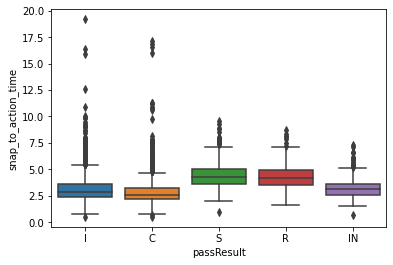

In [19]:
# Boxplot of the snap to action time vs pass result
box = sns.boxplot(data=ol_df, x="passResult", y="snap_to_action_time")
plt.show()

## **Defensive Line Analysis**

### **Individual**

In [20]:
# Get the player-level DL relevant data for players who played more than 30 snaps (to account for noise) 
# Note: potentially consider OLB in DL
high_snap_pass_rushers = player_gen_stat_df.query("position in ['DE','DT','NT'] and roleOnPlay == 'Pass Rush'").nflId.value_counts().loc[lambda c: c > 50].index.tolist()

coi = ['gameId', 'playId', 'nflId', 'season', 'week',
    'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult',
    'prePenaltyPlayResult', 'playerName', 'position', 'snap_to_action_time',
    'distance_at_rel', 'pff_hit', 'pff_hurry', 'pff_sack', 'time_to_depth',
    'numBlockers', 'beatBlocker']
dl_df = (player_gen_stat_df.query(f"nflId in {high_snap_pass_rushers}")
        .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(snap_to_action_df, how='left', on=['gameId','playId'])
        .merge(time_to_depth_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_block_stats_df, how='left', left_on=['gameId','playId','nflId'], right_on=['gameId','playId','nflIdDefender'])[coi])

dl_df.loc[dl_df.numBlockers.astype("float") > 1, 'doubleTeamed'] = 'Y'
dl_df.loc[dl_df.numBlockers.astype("float") == 1, 'doubleTeamed'] = 'N'
dl_df.loc[dl_df.numBlockers.isna(), 'doubleTeamed'] = 'U'

dl_df.loc[dl_df.beatBlocker == 1, 'beatBlockerStr'] = 'Y'
dl_df.loc[dl_df.beatBlocker == 0, 'beatBlockerStr'] = 'N'
dl_df.loc[dl_df.beatBlocker.isna(), 'beatBlockerStr'] = 'U'

indy_dl_pxp_df = dl_df

indy_dl_pxp_df.head()

,gameId,playId,nflId,season,week,offTeam,defTeam,quarter,down,yardsToGo,...,snap_to_action_time,distance_at_rel,pff_hit,pff_hurry,pff_sack,time_to_depth,numBlockers,beatBlocker,doubleTeamed,beatBlockerStr
0,2021090900,97,42403.0,2021,1,TB,DAL,1,3,2,...,3.2,3.805391,0.0,1.0,0.0,1.1,1,0.0,N,N
1,2021090900,97,44955.0,2021,1,TB,DAL,1,3,2,...,3.2,10.437672,0.0,0.0,0.0,1.8,2,0.0,Y,N
2,2021090900,97,53504.0,2021,1,TB,DAL,1,3,2,...,3.2,2.496498,0.0,1.0,0.0,2.0,NaN,NaN,U,U
3,2021090900,137,35441.0,2021,1,DAL,TB,1,1,10,...,2.6,3.635505,0.0,0.0,0.0,1.6,2,0.0,Y,N
4,2021090900,137,35454.0,2021,1,DAL,TB,1,1,10,...,2.6,5.145600,0.0,0.0,0.0,1.9,1,0.0,N,N


In [21]:
# Check for NAs
# A missing snap_to_action_time occurs when a certain play is missing either a snap or action event (can't calculate time)
# A missing time_to_depth occurs when the rusher did not make it to 3 yards (potentially need to use another statistic)
# Missing numBlockers and beatBlocker occurs when a defensive player is unblocked
if sum(indy_dl_pxp_df.isna().sum().values) != 0:
    print(indy_dl_pxp_df.isna().sum().loc[lambda x: x > 0])

snap_to_action_time      68
time_to_depth          3892
numBlockers            1586
beatBlocker            1586
dtype: int64


In [22]:
# Player-level average statistics
coi = ['nflId', 'playerName', 'position', 'snap_to_action_time',
    'distance_at_rel', 'pff_hit', 'pff_hurry', 'pff_sack', 'time_to_depth',
    'numBlockers', 'beatBlocker']

indy_dl_avg_df = indy_dl_pxp_df[coi].groupby(['playerName','nflId','position']).mean().reset_index().sort_values(by=['beatBlocker'], ascending=[False])

indy_dl_avg_df.head()

,playerName,nflId,position,snap_to_action_time,distance_at_rel,pff_hit,pff_hurry,pff_sack,time_to_depth,beatBlocker
138,Myles Garrett,44813.0,DE,3.083886,4.612210,0.042654,0.137441,0.056872,1.407000,0.146597
2,Aaron Donald,41239.0,DT,3.042857,4.934059,0.030769,0.092308,0.023077,1.645494,0.143443
71,Everson Griffen,35539.0,DE,3.015607,4.749828,0.028902,0.092486,0.028902,1.582119,0.125786
32,Charles Omenihu,47944.0,DE,3.165657,5.268134,0.040000,0.120000,0.000000,1.619540,0.125000
47,Danielle Hunter,42431.0,DE,3.183582,4.616292,0.014851,0.128713,0.029703,1.713757,0.119048


In [23]:
# Player-level blocking stat frequencies
# Frequencies of "doubleTeamed" on passing plays grouped by player
coi = ['nflId', 'playerName', 'position', 'doubleTeamed']

(indy_dl_pxp_df[coi]
.groupby(['nflId', 'playerName', 'position'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['doubleTeamed','%'],ascending=[False,False])
.head(5))

,nflId,playerName,position,doubleTeamed,%
58,39960.0,Star Lotulelei,DT,Y,0.660550
225,43638.0,Justin Zimmer,DT,Y,0.659574
49,38619.0,Akiem Hicks,DT,Y,0.632653
348,46249.0,Folorunso Fatukasi,DT,Y,0.628099
283,44957.0,Grover Stewart,DT,Y,0.619718


In [24]:
# Frequencies of "beatBlockerStr" on passing plays grouped by player
coi = ['nflId', 'playerName', 'position', 'beatBlockerStr']

(indy_dl_pxp_df[coi]
.groupby(['nflId', 'playerName', 'position'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['beatBlockerStr','%'],ascending=[False,False])
.head(5))

,nflId,playerName,position,beatBlockerStr,%
85,41239.0,Aaron Donald,DT,Y,0.134615
231,44813.0,Myles Garrett,DE,Y,0.132701
17,35539.0,Everson Griffen,DE,Y,0.115607
408,47944.0,Charles Omenihu,DE,Y,0.110000
170,43318.0,Robert Nkemdiche,DT,Y,0.109375


In [25]:
# Frequencies of doubleTeamed/beatBlockerStr on passing plays grouped by player
coi = ['nflId', 'playerName', 'position', 'doubleTeamed','beatBlockerStr']

(indy_dl_pxp_df[coi]
.groupby(['nflId', 'playerName', 'position'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['beatBlockerStr','%'],ascending=[False,False])
.head(5))


,nflId,playerName,position,doubleTeamed,beatBlockerStr,%
374,44813.0,Myles Garrett,DE,N,Y,0.118483
656,47944.0,Charles Omenihu,DE,N,Y,0.110000
29,35539.0,Everson Griffen,DE,N,Y,0.092486
138,41239.0,Aaron Donald,DT,Y,Y,0.092308
213,42431.0,Danielle Hunter,DE,N,Y,0.089109
